In [5]:
# from google.colab import drive
# drive.mount('/content/drive')
# !cp -r "/content/drive/My Drive/NLP/assignment1/." "./"

In [6]:
# !pip install -r requirements.txt

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import os
import functools
import random
import itertools
from typing import List, Callable, Dict, Iterable, Tuple, Set, Optional, Literal
from collections import OrderedDict
from enum import Flag, auto

import wordcloud
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import tensorflow as tf
import tensorflow_addons as tfa
import keras as ks
import keras.backend as K
import keras_tuner

import gensim
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay

import config
from config import *
from util import *
from embedding import *
from preprocessing import *

In [5]:
tf.config.list_physical_devices('GPU')

[]

In [6]:
!nvidia-smi

Tue Jan 10 17:07:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.81       Driver Version: 511.81       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   42C    P8    13W /  N/A |    216MiB /  6144MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def get_variables(module_name):
    module = globals().get(module_name, None)
    variables = {}
    if module:
        variables = {key: value for key, value in module.__dict__.items() if not (
            key.startswith('__') or key.startswith('_'))}
    return variables

print(get_variables('config'))

## 1. Dataset Loading

In [ ]:
def read_tagged_sentences(filename: str) -> List[str]:
    with open(filename, mode='r', encoding='utf-8') as text_file:  
        corpus = text_file.read()
        return corpus.split("\n\n")

def get_tagged_words(tagged_sentence: str) -> List[str]:
    return tagged_sentence.rstrip('\n').split("\n")

def split_words_and_tags(tagged_words: List[str]) -> Tuple[List[str], List[str]]:
    words = []
    tags = []
    for tagged_word in tagged_words:
        word, tag = split_word_and_tag(tagged_word)
        words.append(word)
        tags.append(tag)
    return words, tags

def split_word_and_tag(tagged_word: str) -> Tuple[str, str]:
    entity = tagged_word.split("\t")
    # (word, tag)
    return entity[0], entity[1]

def read_data(filename) -> Tuple[List[str], List[str]]:
    tagged_sentences = read_tagged_sentences(filename)
    
    sentences: List[str] = []
    labels: List[str] = []
    for tagged_sentence in tagged_sentences:
        tagged_words = get_tagged_words(tagged_sentence)
        words, tags = split_words_and_tags(tagged_words)
        sentences.append(words_separator.join(words))
        labels.append(words_separator.join(tags))

    assert len(sentences) == len(tagged_sentences)
    assert len(labels) == len(tagged_sentences)

    return sentences, labels

def create_dataset(dataset_name="dependency_treebank", train_split=100, validation_split=150, test_split=199):
    def file_id_to_split(file_id: int):
        assert file_id <= test_split

        if file_id <= train_split:
            return 'train'
        if file_id <= validation_split:
            return 'validation'
        
        return 'test'

    dataset_folder = os.path.join(os.getcwd(), dataset_name)
    file_ids = []
    sentences = []
    labels = []
    for file_id in tqdm(range(1, test_split+1)):
        filename = os.path.join(dataset_folder, "wsj_%04d.dp" % file_id)
        sentences_, labels_ = read_data(filename)
        sentences += sentences_
        labels += labels_
        file_ids += [file_id] * len(sentences_)
         
    df = pd.DataFrame({'sentence': sentences, 'pos': labels, 'file_id': file_ids})
    df['split'] = df['file_id'].apply(file_id_to_split)
    
    df.to_pickle(os.path.join(dataset_folder, dataset_name + ".pkl"))
    df.to_json(os.path.join(dataset_folder, dataset_name + ".json"))
    return df

print("Creating dataset...")
df = create_dataset(dataset_name=dataset_name)
print("Creation completed!")

df

In [ ]:
train_data, val_data, test_data = split_dataset(df)
print('Dataset splits statistics: ')
print(f'Train data: {train_data.shape}')
print(f'Validation data: {val_data.shape}')
print(f'Test data: {test_data.shape}')

# 2. Data Exploration and Analysis

## 2.1 Words analysis

In [ ]:
# We should not look at test data
data = df[df['split'] != 'test'].copy()

words = set(flatten((sentence.split(words_separator) for sentence in data.sentence)))
lowered_case_words = set(map(str.lower, words))
n_words = len(words)

print("Total number of tagged sentences: {}".format(len(data)))
print("Total number of words: {}".format(n_words))
print("Total number of lowered case words: {}".format(len(lowered_case_words)))

In [ ]:
difference = words.difference(lowered_case_words)
print(len(difference))
difference

There are sveral uppercase words:
1. -RRB-, -LRB- are already encoded into their tags
2. Some of them are abbreviations, e.g. U.S.A.
3. Some of them seem to be part of a title, e.g. LONDON, BIRDS

In [ ]:
uppercase_words = [word for word in difference if str.isupper(word)]
tags = set(flatten((pos.split(words_separator) for pos in df.pos)))
print('Words encoded into their tags', tags.intersection(uppercase_words))
uppercase_words

Words starting with capital letter are proper nouns or words at the beginning of a sentence. Therefore, this carries an important piece of information for POS tagging.

In [ ]:
capitalized_words = set([word for word in difference if str.isupper(word[0])])
capitalized_words = capitalized_words.difference(uppercase_words)
print('Capitalized words:', len(capitalized_words))
capitalized_words

In [ ]:
contains_digits = set([word for word in words if has_digits(word)])
numbers = set([word for word in contains_digits if is_number(word)])
non_numbers = contains_digits.difference(numbers)
print("Total number of words with digits:", len(contains_digits))
print("Total number of numbers:", len(numbers))
print("Total number of words with digits but that are not numbers:", len(non_numbers))
print(non_numbers)

We have several wrongly escaped fractions, such as `6\\/2`, `1\\/4`, etc.

## 2.2 Classes Analysis

![tags](images/tags.png)

In [ ]:
tags = set(flatten((pos.split(words_separator) for pos in df.pos)))
n_tags   = len(tags)
evaluation_tags = tags.difference(punctuation_tags)
n_evaluation_tags = len(evaluation_tags)
n_punctuation_tags = len(punctuation_tags)

print("Total number of tags:", n_tags)
print('Tags')
print(sorted(tags))
print()
print("Total number of tags valid for evaluation:", n_evaluation_tags)
print("Total number of punctuation tags:", n_punctuation_tags)
print('Punctuation tags')
print(punctuation_tags)

In [ ]:
tags = df[['pos', 'split']].copy()
tags['pos'] = tags['pos'].str.split(words_separator)
tags = tags.explode('pos')

The dataset is highly unbalanced: nouns, prepositions and proper nouns are the most common labels.

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.countplot(tags, x='pos', order=tags['pos'].value_counts().index, ax=ax);
plt.title('Class Distribution')
plt.ylabel('# of Training Samples')
plt.xticks(rotation = 45);

Classes are similarly distributed across the three splits

In [ ]:
frequencies = (tags
    .groupby('split')['pos']
    .value_counts(normalize=True)
    .mul(100)
    .rename('frequency')
    .reset_index())

fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(frequencies, x='pos', y='frequency', hue='split', ax=ax);
plt.title('Class frequencies')
plt.ylabel('Frequency')
plt.xticks(rotation = 45);

In [ ]:
label_counts = pd.get_dummies(tags, columns=['pos'], prefix='', prefix_sep='').groupby('split').sum().reset_index()
cols = label_counts.columns[1:]
count_by_split = np.expand_dims(label_counts[cols].sum(axis=1), axis=1)
label_counts[cols] = label_counts[cols] / count_by_split
label_counts = label_counts.T.reset_index().rename(columns={'index':'pos', 0:'test', 1:'train', 2:'val'})[1:]
label_counts['punctuation'] = label_counts['pos'].isin(punctuation_tags)
label_counts.sort_values('test', ascending=False)

In [ ]:
label_counts.groupby('punctuation').sum().drop('pos', axis=1)

Some classes are not present in the test set or in the validation set. In particular FW (foreign words), LS (list item markers), and UH (interjections)

In [ ]:
cols = label_counts.columns[1:-1]
label_counts.loc[(label_counts[cols] == 0).any(axis=1)]

## 2.3 Length Analysis

In [ ]:
# We should not look at test data
data = df[df['split'] != 'test'].copy()
data['length'] = data['sentence'].str.split(words_separator).apply(len)

data['length'].describe()

In [ ]:
sns.boxplot(x=data['length']);

# 3. Data Preprocessing

*Text preprocessing*

We have lower case, upper case and capitalized words. Here we define three different strategies for preprocessing texts we will test:
- None: nothing is done
- lower: convert all words to the corresponding lower case string
- lower_up: convert only upper case words to the corresponding lower case string

The rationale of lower_up is that the upper case do not drive any information, therefore we make them lower to exploit embedding while preserving the case for capitalized words.

*Numbers preprocessing*

- None: nothing is done
- token: all numbers are replaced with a common token

See [preprocessing.py](preprocessing.py)

In [ ]:
dataset = df.copy()
dataset['sentence'] = dataset['sentence'].apply(preprocess_text)
train_data, val_data, test_data = split_dataset(dataset)
dataset

# 4. Embedding

In [ ]:
embedding_model = download_embedding_model(model_type=model_type, embedding_dimension=embedding_dimension)
embedding_model.save(embedding_model_file)

## 4.1 Embedding Analysis

In [ ]:
embedding_words = set(embedding_model.key_to_index.keys())
n_embedding_words = len(embedding_words)
print("Total number of words into embeddings:", n_embedding_words)
lower = [word for word in embedding_words if str.islower(word)]
print("All lowercase?", len(lower) == n_embedding_words)

In [ ]:
embedding_contains_digits = set([word for word in embedding_words if has_digits(word)])
embedding_numbers = set([word for word in embedding_contains_digits if is_number(word)])
embedding_non_numbers = embedding_contains_digits.difference(embedding_numbers)
print("Total number of embedding words with digits:", len(embedding_contains_digits))
print(list(embedding_contains_digits)[:100])
print()
print("Total number of embedding numbers:", len(embedding_numbers))
print(list(embedding_numbers)[:100])
print()
print("Total number of embedding words with digits but that are not numbers:", len(embedding_non_numbers))
print(list(embedding_non_numbers)[:300])

In [ ]:
discard = set(lower).union(embedding_contains_digits)
remaining = embedding_words.difference(discard)
print('Total number of words that are neither lower case text nor words with digits:', len(remaining))
print(remaining)

## 4.2 Handling OOV
From the analysis above, we can see that all words in glove are lower case. Words that contains numbers are compositions of numbers-text. We can handle OOV in the following way:
- composed-words: we take as vector the mean of the single words vectors
- numbers: we consider one common embedding vector for all the numbers taken as the mean of all the numbers vectors
- capitalized words: we add to the corresponding lower case vector a common "capitalize" vector

See [embedding.py](embedding.py)
For time reasons, we compute the embeddings for the three dataset (separately), with the script mentioned above. Here, we show an example.

In [ ]:
dataset, embedding_matrix = preprocess_and_create_embedding(df, embedding_model_file, text_strategy='lower')

# 5. Data Preparation

In [ ]:
train_data, val_data, test_data = split_dataset(dataset)

## 5.1 Tokenizer

In [ ]:
class TextVectorization:
    def __init__(self, word_to_id: Dict[str, int], sep=' ') -> None:
        self.sep = sep

        words = list(word_to_id.keys())
        values = list(word_to_id.values())
        self.word_to_id = tf.lookup.StaticHashTable(
            initializer=tf.lookup.KeyValueTensorInitializer(words, values),
            default_value=-1
        )
        self.id_to_word = tf.lookup.StaticHashTable(
            initializer=tf.lookup.KeyValueTensorInitializer(values, words),
            default_value='[UNK]'
        )
        assert self.word_to_id.size() == len(word_to_id)
        assert self.id_to_word.size() == len(word_to_id)

    def vectorize(self, text) -> tf.RaggedTensor:
        tokens = self.tokenize(text)
        return self.tokens_to_ids(tokens)
    
    def invert(self, ids: tf.RaggedTensor) -> tf.RaggedTensor:
        tokens = self.ids_to_tokens(ids)
        texts = tf.strings.reduce_join(tokens, separator=self.sep, axis=-1)
        return texts

    def tokenize(self, text) -> tf.RaggedTensor:
        tokens = tf.strings.split(text, sep=self.sep)
        return tokens

    def tokens_to_ids(self, tokens: tf.RaggedTensor | list | tuple | np.ndarray) -> tf.RaggedTensor:        
        if isinstance(tokens, (list, tuple, np.ndarray)):
            tokens = tf.ragged.constant(tokens)
        return tf.ragged.map_flat_values(self.word_to_id.lookup, tokens)
    
    def ids_to_tokens(self, ids: tf.RaggedTensor) -> tf.RaggedTensor:        
        ids = tf.cast(ids, tf.int32)
        tokens = tf.ragged.map_flat_values(self.id_to_word.lookup, ids)
        return tokens

class LabelEncoder(TextVectorization):
    def __init__(self, word_to_id: Dict[str, int], sep=' ', ignore_padding=False) -> None:
        super().__init__(word_to_id, sep)
        self.ignore_padding = ignore_padding
        self.one_hot_dimension = len(word_to_id)
        if ignore_padding:
            self.one_hot_dimension -= 1
    
    def ids_to_one_hot(self, ids: tf.RaggedTensor | list | tuple | np.ndarray) -> tf.RaggedTensor:
        if isinstance(ids, (list, tuple, np.ndarray)):
            ids = tf.ragged.constant(ids)

        if self.ignore_padding:
            # supposing padding=0 -> padding=-1 -> padding = [0,...,0]
            ids -= 1
            
        return tf.one_hot(ids, depth=self.one_hot_dimension)

    def one_hot_to_ids(self, one_hot: tf.RaggedTensor | tf.Tensor | list | tuple | np.ndarray) -> tf.RaggedTensor | tf.Tensor:
        ids = tf.ragged.map_flat_values(tf.argmax, one_hot, axis=-1, output_type=tf.int32)
        
        if self.ignore_padding:
            ids += 1

        return ids
    
    def one_hot_encode(self, text) -> tf.RaggedTensor:
        ids = self.vectorize(text)
        return self.ids_to_one_hot(ids)
    
    def one_hot_decode(self, one_hot) -> tf.RaggedTensor:
        ids = self.one_hot_to_ids(one_hot)
        return self.invert(ids)

In [ ]:
tags = set(flatten((pos.split(words_separator) for pos in df.pos)))
label_vocabulary = {tag: id for tag, id in zip(tags, range(1, n_tags + 1))}
label_vocabulary[''] = 0
assert len(label_vocabulary) == n_tags + 1

print(label_vocabulary)

In [ ]:
tokenizer = TextVectorization(embedding_matrix.vocabulary(), sep=words_separator)
label_encoder = LabelEncoder(label_vocabulary, sep=words_separator)

assert tf.reduce_all(tokenizer.invert(tokenizer.vectorize(train_data.sentence.values)) == tf.constant(train_data.sentence.values))
assert tf.reduce_all(label_encoder.invert(label_encoder.vectorize(train_data.pos.values)) == tf.constant(train_data.pos.values))
assert tf.reduce_all(label_encoder.one_hot_decode(label_encoder.one_hot_encode(train_data.pos.values)) == tf.constant(train_data.pos.values))

## 5.2 Dataloader

In [ ]:
def prepare_data(
  dataset: pd.DataFrame,
  tokenizer: TextVectorization,
  label_encoder: LabelEncoder,
  class_weights=None):

  sentences = tokenizer.vectorize(dataset['sentence'])
  ids = label_encoder.vectorize(dataset['pos'])
  one_hot_labels = label_encoder.ids_to_one_hot(ids)
  
  prepared_data = sentences, one_hot_labels
  if class_weights is not None:
    sample_weights:tf.RaggedTensor = tf.ragged.map_flat_values(lambda tags: tf.constant(class_weights[tags]), ids)
    prepared_data = *prepared_data, sample_weights

  return prepared_data

def pad(sentences: tf.RaggedTensor, tags: tf.RaggedTensor, sample_weigths=None):
  sentences = sentences.to_tensor(default_value=0)
  tags = tags.to_tensor(default_value=0)

  data = sentences, tags
  if sample_weigths is not None:
    sample_weigths = sample_weigths.to_tensor(default_value=0)
    data = *data, sample_weigths

  return data

def create_dataloader(prepared_data: Tuple, batch_size=32, training=True):
  dataset = (
      tf.data.Dataset.from_tensor_slices(prepared_data)
  )
  
  if training:
    dataset = dataset.shuffle(buffer_size=2048)

  dataset = (
      dataset
      .batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
      .map(pad, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE)
      )
  
  return dataset

class_weights = np.ones(n_tags + 1)
prepared_train_data = prepare_data(train_data, tokenizer, label_encoder, class_weights=class_weights)
prepared_val_data = prepare_data(val_data, tokenizer, label_encoder, class_weights=class_weights)
dataloader = create_dataloader(prepared_train_data)

In [ ]:
batched_text, batched_tags, sample_weigths = next(dataloader.take(1).as_numpy_iterator())
text = batched_text[0]
tags = batched_tags[0]
sample_weigths = sample_weigths[0]

print('Encoded text:', text.shape)
print(text)
print('One hot encoded tags:', tags.shape)
print(list(tags))
print('Sample weights:', sample_weigths.shape)
print(list(sample_weigths))

# 6. Architectures

We want to try 4 different architectures:
- base: embedding + lstm + fc
- gru: embedding + gru + fc
- additional_lstm: embedding + lstm + lstm + fc
- additional_dense: embedding + lstm + fc + fc

In [ ]:
class TimeDistributedDense(ks.layers.TimeDistributed):
  def __init__(self, *dense_args, **dense_kwargs) -> None:
        super().__init__(ks.layers.Dense(*dense_args, **dense_kwargs))

class Seq2SeqPosModel(ks.Model):
  def __init__(self, 
              embedding_weights,
              num_classes,
              rnn_units=128,
              use_gru=False, 
              additional_lstm=False,
              additional_dense=False,
              additional_dense_units=10,
              dropout=0.0,
              multi_label=False,
              class_frequencies=None,
              **kwargs):
    """
    Parameters
      ----------
      rnn_units: int
          The hidden state's dimension of the RNNs
      use_gru: bool
          If True, use a BiGRU layer instead of the BiLSTM
      additional_lstm: bool
          If True, use an additional BiLSTM layer right after the default one
      additional_dense: bool
          If True, adds a FC layer before the classifier
      additional_dense_units: int
        The hidden state's dimension of the additional dense layers
      dropout: float
          Define the drop rate of the Dropout layers. By default the dropout is disabled
      multi_label: bool
        If True, the problem is considered to be multi-label and the last layer uses sigmoid instead of softmax      
    """
    super().__init__(**kwargs)
    self.embedding = ks.layers.Embedding(*embedding_weights.shape, weights=[embedding_weights],
                            mask_zero=True, trainable=False)

    self.rnn_layers = []
    if use_gru:
      assert not additional_lstm and not additional_dense, "use_gru cannot be used together with additional_lstm or additional_dense"
      rnn = ks.layers.GRU(units=rnn_units, return_sequences=True, dropout=dropout, name='gru')
    else:
      rnn = ks.layers.LSTM(units=rnn_units, return_sequences=True, dropout=dropout, name='lstm')      
    self.rnn_layers.append(ks.layers.Bidirectional(rnn, name=f'bidirectional_{rnn.name}'))

    if additional_lstm:
      assert not use_gru and not additional_dense, "additional_lstm cannot be used together with use_gru or additional_dense"
      rnn = ks.layers.LSTM(units=rnn_units, return_sequences=True, dropout=dropout)
      self.rnn_layers.append(ks.layers.Bidirectional(rnn, name='bidirectional_lstm2'))

    self.fc_layers = []
    if additional_dense:
      assert not use_gru and not additional_lstm, "additional_dense cannot be used together with use_gru or additional_lstm"
      assert additional_dense_units > 0
      self.fc_layers.append(TimeDistributedDense(additional_dense_units, activation='relu'))
      if dropout:
        self.fc_layers.append(ks.layers.Dropout(dropout))

    if multi_label:
      initial_biases = "zeros"
      if class_frequencies:
        initial_biases = - np.log((1-class_frequencies)/class_frequencies)
        initial_biases = tf.constant(initial_biases)
      output_layer = TimeDistributedDense(num_classes, activation='sigmoid', bias_initializer=initial_biases, dtype=np.float32)
    else:
      output_layer = TimeDistributedDense(num_classes+1, activation='softmax', dtype=np.float32)
    self.output_layer = output_layer

  def call(self, inputs, **kwargs):
    x = self.embedding(inputs, **kwargs)
    for rnn in self.rnn_layers:
      x = rnn(x, **kwargs)
    for fc in self.fc_layers:
      x = fc(x, **kwargs)

    return self.output_layer(x, **kwargs)

  # def train_step(self, data):
  #   # Unpack the data. Its structure depends on your model and
  #   # on what you pass to `fit()`.
  #   if len(data) == 3:
  #       x, y, sample_weight = data
  #   else:
  #       sample_weight = None
  #       x, y = data
    
  #   compute_blacklist_mask()
  #   ks.utils.losses_utils.

  #   with tf.GradientTape() as tape:
  #     y_pred = self(x, training=True)  # Forward pass
  #     # Compute the loss value.
  #     # The loss function is configured in `compile()`.
  #     loss = self.compiled_loss(
  #         y,
  #         y_pred,
  #         sample_weight=sample_weight,
  #         regularization_losses=self.losses,
  #     )

  #   # Compute gradients
  #   trainable_vars = self.trainable_variables
  #   gradients = tape.gradient(loss, trainable_vars)

  #   # Update weights
  #   self.optimizer.apply_gradients(zip(gradients, trainable_vars))

  #   # Update the metrics.
  #   # Metrics are configured in `compile()`.
  #   self.compiled_metrics.update_state(y, y_pred, sample_weight=sample_weight)

  #   # Return a dict mapping metric names to current value.
  #   # Note that it will include the loss (tracked in self.metrics).
  #   return {m.name: m.result() for m in self.metrics}

class ModelFactory():
  def __init__(self, embedding_weights, n_classes, class_frequencies=None):
    self.embedding_weights=embedding_weights
    self.num_classes=n_classes
    self.class_frequencies = class_frequencies
  
  def create_model(self,
              rnn_units=128,
              use_gru=False, 
              additional_lstm=False,
              additional_dense=False,
              additional_dense_units=10,
              dropout=0.0,
              multi_label=False,
              name = None) -> Seq2SeqPosModel:
    """
    Parameters
      ----------
      rnn_units: int
          The hidden state's dimension of the RNNs
      use_gru: bool
          If True, use a BiGRU layer instead of the BiLSTM
      additional_lstm: bool
          If True, use an additional BiLSTM layer right after the default one
      additional_dense: bool
          If True, adds a FC layer before the classifier
      additional_dense_units: int
        The hidden state's dimension of the additional dense layers
      dropout: float
          Define the drop rate of the Dropout layers. By default the dropout is disabled
      multi_label: bool
        If True, the problem is considered to be multi label and the last layer uses sigmoid instead of softmax
      name: str
          The name of the model          
      Returns
      -------
      tensorflow.keras.models.Model
          The POS-tagging model          
    """
    
    return Seq2SeqPosModel(embedding_weights=self.embedding_weights,
              num_classes=self.num_classes,              
              class_frequencies=self.class_frequencies,
              rnn_units=rnn_units,
              use_gru=use_gru, 
              additional_lstm=additional_lstm,
              additional_dense=additional_dense,
              additional_dense_units=additional_dense_units,
              dropout=dropout,
              multi_label=multi_label)

In [ ]:
models = {}
models['base'] = {
    'name': 'base',
    'use_gru': False,
    'additional_lstm': False,
    'additional_dense': False,
}
models['gru'] = {
    'name': 'gru',
    'use_gru': True,
    'additional_lstm': False,
    'additional_dense': False,
}
models['additional_lstm'] = {
    'name': 'additional_lstm',
    'use_gru': False,
    'additional_lstm': True,
    'additional_dense': False,
}
models['additional_dense'] = {
    'name': 'additional_dense',
    'use_gru': False,
    'additional_lstm': False,
    'additional_dense': True,
}

model_factory = ModelFactory(embedding_matrix.vectors(), n_classes=n_tags)
for model_name, architecture in models.items():
    model = model_factory.create_model(**architecture)  
    model.build((None, None))
    model.call(ks.layers.Input((None, )))
    model.summary()
    print()

Here we ensure that the initial loss is equal to $-log(1/(n\_tags+1)) \approx 3.8286$

In [ ]:
def check_init_loss(multilabel=False):    
    if multilabel:
        classification_type = 'Multi-label'
        loss = 'binary_crossentropy'
        expected_loss = np.log(2)
    else:
        classification_type = 'Multi-class'
        loss = 'categorical_crossentropy'
        expected_loss = np.log(n_tags+1)
    
    compile_info = {
        'optimizer': ks.optimizers.Adam(learning_rate=1e-3),
        'loss': loss,
        'metrics': ['categorical_accuracy'],
    }
    model = model_factory.create_model(multi_label=multilabel)
    model.compile(**compile_info)

    label_encoder = LabelEncoder(label_vocabulary, sep=words_separator, ignore_padding=multilabel)
    prepared_train_data = prepare_data(train_data.iloc[:5000], tokenizer, label_encoder)
    dataloader = create_dataloader(prepared_train_data, batch_size=512, training=False)
    samples = next(dataloader.take(1).as_numpy_iterator())[0]
    samples = tf.constant(samples[:10])
    output = model(samples)
    results = model.evaluate(dataloader, verbose=0)


    print(classification_type, 'Problem')
    print('Sample output:', output)
    print('Expected loss:', expected_loss)
    print("Loss: {:0.4f}".format(results[0]))

In [ ]:
check_init_loss()

# 7. Defining Model Evaluations

In this section, we define evaluation functions. In particular, we create functions to mask padding and punctuation tags, then we define a class to evaluate the dataset according to the metrics provided.

In [ ]:
class PosEvaluator():
  def __init__(self, label_encoder:LabelEncoder, banned_tags:Iterable[str]) -> None:
    self.label_encoder = label_encoder
    self.banned_tags = label_encoder.tokens_to_ids(banned_tags).numpy()

  def compute_padding_mask(self, y_true: tf.Tensor) -> tf.Tensor:
    return y_true != 0

  def compute_mask(self, y_true: tf.Tensor, remove_banned_tags=True) -> tf.Tensor:
    mask = self.compute_padding_mask(y_true)
    if remove_banned_tags:
      blacklist_mask = compute_blacklist_mask(y_true, self.banned_tags)
      mask = tf.logical_and(mask, blacklist_mask)

    return mask

  def compute_mask_from_onehot(self, y_onehot: tf.Tensor, remove_banned_tags=True) -> tf.Tensor:
    ids: tf.Tensor = self.label_encoder.one_hot_to_ids(y_onehot)
    mask = self.compute_mask(ids, remove_banned_tags=remove_banned_tags)
    return mask

  def apply_mask(self, x: tf.Tensor, mask) -> tf.RaggedTensor:
    return tf.ragged.boolean_mask(x, mask)  

  def evaluate(self, model: ks.Model, x:tf.RaggedTensor, y:tf.RaggedTensor, metrics:Dict[str, Callable]) -> Tuple[tf.Tensor, tf.Tensor, Dict[str, object]]:
    y_pred = self.predict(model, data)    
    return self.evaluate_predictions(y, y_pred, metrics)

  def predict(self, model: ks.Model, x:tf.Tensor, y:tf.Tensor) -> np.ndarray:
    print('Making predictions ...')
    y_pred = model.predict(x, verbose=True)
    assert y_pred.shape == y.shape
    
    return y_pred

  def evaluate_predictions(self,
    y_true: tf.Tensor,
    y_pred: tf.Tensor,
    metrics: Dict[str, Callable]) -> Tuple[tf.Tensor, tf.Tensor, Dict[str, object]]:
    """
      Evaluates given model predictions on a list of metric functions

      :param y_pred: one hot encoded predictions
      :param y_true: one hot encoded ground-truth labels
      :param metrics: dictionary of (metric_name, metric_fn)

      :return
        - filtered prediction labels
        - filtered true lables
        - metric_info: dictionary containing metric values for each input metric
      """
    assert y_pred.shape == y_true.shape
    print(f"Evaluating predictions! Total samples: {y_pred.shape[0]}")

    y_true = self.label_encoder.one_hot_to_ids(y_true)
    y_pred = self.label_encoder.one_hot_to_ids(y_pred)
    assert y_pred.shape == y_true.shape

    mask = self.compute_mask(y_true, remove_banned_tags=True)
    masked_true = self.apply_mask(y_true, mask)
    masked_pred = self.apply_mask(y_pred, mask)    

    masked_pred = np.array(tf.reshape(masked_pred, -1), dtype=np.int32)
    masked_true = np.array(tf.reshape(masked_true, -1), dtype=np.int32)

    metric_info = {}
    for metric_name, metric in metrics.items():
        metric_value = metric(y_pred=masked_pred, y_true=masked_true)
        metric_info[metric_name] = metric_value

    return masked_pred, masked_true, metric_info

def print_metrics(metric_info: Dict[str, object]):
  for metric_name, metric, in metric_info.items():
      print(f'{metric_name}:')
      print(metric)

# Test masking to ensure code changes do not break the logic
def _test_masking():
  print('Testing evaluation functions ...')
  banned_tags = ['NN', 'CC', 'JJ']

  y = [['NN', 'RBR', 'CC', '', ''], ['JJ', 'JJ', 'IN', 'WDT', '']]
  y = label_encoder.tokens_to_ids(y)  

  evaluator = PosEvaluator(label_encoder, banned_tags)

  padding_mask = evaluator.compute_padding_mask(y)
  assert padding_mask.shape == y.shape, f'{padding_mask.shape} != {y.shape}'
  assert tf.reduce_all(padding_mask == tf.constant([[True, True, True, False, False], [True, True, True, True, False]]))

  blacklist_mask = compute_blacklist_mask(y, label_encoder.tokens_to_ids(banned_tags).numpy())
  assert blacklist_mask.shape == y.shape, f'{blacklist_mask.shape} != {y.shape}'
  assert tf.reduce_all(blacklist_mask == tf.constant([[False, True, False, True, True], [False, False, True, True, True]]))

  mask = evaluator.compute_mask(y)
  assert mask.shape == y.shape, f'{mask.shape} != {y.shape}'
  assert tf.reduce_all(mask == tf.constant([[False, True, False, False, False], [False, False, True, True, False]]))

  y_onehot = label_encoder.ids_to_one_hot(y)
  mask = evaluator.compute_mask_from_onehot(y_onehot)
  assert mask.shape == y.shape, f'{mask.shape} != {y.shape}'
  assert tf.reduce_all(mask == tf.constant([[False, True, False, False, False], [False, False, True, True, False]]))

  y_true = [['NN', 'RBR', 'CC', '', ''], ['JJ', 'JJ', 'IN', 'WDT', '']]
  y_pred = [['NN', 'WDT', 'CC', '', ''], ['JJ', 'CC', 'IN', 'WDT', '']]
  y_true = label_encoder.tokens_to_ids(y_true).to_tensor(0)
  y_pred = label_encoder.tokens_to_ids(y_pred).to_tensor(0)
  assert y_true.shape == y_pred.shape
  
  mask = evaluator.compute_mask(y_true)
  true = evaluator.apply_mask(y_true, mask)
  pred = evaluator.apply_mask(y_pred, mask)
  assert pred.shape == true.shape
  assert tf.reduce_all(pred == label_encoder.tokens_to_ids([['WDT'], ['IN', 'WDT']]))
  assert tf.reduce_all(true == label_encoder.tokens_to_ids([['RBR'], ['IN', 'WDT']]))
  
  print('Test successfully completed!')
_test_masking()

In [ ]:
macro_f1 = functools.partial(f1_score, zero_division=0, average='macro')

def masked_macro_f1(y_true, y_pred, mask=None):        
    y_true = tf.argmax(y_true, output_type=tf.int32, axis=-1)
    y_pred = tf.argmax(y_pred, output_type=tf.int32, axis=-1)
    
    if mask is not None:
        y_true = tf.ragged.boolean_mask(y_true, mask)
        y_pred = tf.ragged.boolean_mask(y_pred, mask)

    y_true = np.array(tf.reshape(y_true, -1), dtype=np.int32)
    y_pred = np.array(tf.reshape(y_pred, -1), dtype=np.int32)

    return macro_f1(y_true, y_pred)

class F1History(tf.keras.callbacks.Callback):
    def __init__(self, validation, mask=None):
        super(F1History, self).__init__()
        self.x_val = validation[0]
        self.y_val = validation[1]
        self.mask = mask

    def on_epoch_end(self, epoch, logs={}):
        logs['val_f1'] = float('-inf')
        y_val_pred = self.model.predict(self.x_val, verbose=0)
        val_score = masked_macro_f1(self.y_val, y_val_pred, self.mask)
        logs['val_f1'] = np.round(val_score, 5)

def get_f1_callback(prepared_val_data, pos_evaluator: PosEvaluator):
    x_val, y_val = pad(prepared_val_data[0], prepared_val_data[1])
    mask = pos_evaluator.compute_mask_from_onehot(y_val)

    return F1History((x_val, y_val), mask)

In [ ]:
tags = list(label_vocabulary.keys())
encoded_tags = list(label_encoder.tokens_to_ids(tags).numpy())
metrics = {
    'macro_f1': macro_f1,
    'classification report': functools.partial(classification_report, zero_division=0, labels=encoded_tags, target_names=tags),
}

def run_fake_evaluation():
    data = train_data.iloc[:1000]

    x, y_true = pad(*prepare_data(data, tokenizer, label_encoder))
    y_pred = pos_evaluator.predict(model, x, y_true)

    assert y_pred.shape[0] == len(data)
    max_length = data['sentence'].str.split(words_separator).apply(len).max()
    assert y_pred.shape[1] == max_length

    print(y_pred.shape)
    print(y_pred[:10])

    y_true_masked, y_pred_masked, metric_info = pos_evaluator.evaluate_predictions(y_true=y_true, y_pred=y_pred, metrics=metrics)

    assert y_pred_masked.shape == y_true_masked.shape
    n_non_banned = np.count_nonzero(~data['pos'].str.split(words_separator).explode().isin(punctuation_tags))
    assert y_pred_masked.shape[0] == n_non_banned

    return metric_info

pos_evaluator = PosEvaluator(label_encoder, banned_tags=punctuation_tags)
metric_info = run_fake_evaluation()

In [ ]:
print_metrics(metric_info)

# 8. Training Baseline Model

Here, we define training methods and run them on the baseline model.

In [ ]:
def show_history(history: ks.callbacks.History):
    """
    Shows training history data stored by the History Keras callback

    :param history: History Keras callback
    """
    history_data = history.history
    print(f"Displaying the following history keys: {history_data.keys()}")

    for key, value in history_data.items():
        if not key.startswith('val'):
            plot_history_item(history_data, key)
    if 'val_f1' in history_data:
        plot_history_item(history_data, 'val_f1', legend=['val'])
    plt.show()

def plot_history_item(history_data: dict, key: str, legend=['train', 'val']):
    fig, ax = plt.subplots(1, 1)
    ax.set_title(key)
    ax.plot(history_data[key])
    if f'val_{key}' in history_data:
        ax.plot(history_data[f'val_{key}'])

    ax.set_ylabel(key)
    ax.set_xlabel('epoch')
    ax.legend(legend, loc='best')
    

In [ ]:
def train_model(model: ks.Model,
                train_data: tf.data.Dataset,
                val_data: tf.data.Dataset,
                training_info: Dict,
                show=True):
    """
    Training routine for the Keras model.
    At the end of the training, retrieved History data is shown.

    :param model: Keras built model
    :param train_data: training data
    :param val_data: validation data
    :param training_info: dictionary storing model fit() argument information

    :return
        model: trained Keras model
    """
    print(f"Start training! \nParameters: {training_info}")
    history = model.fit(x=train_data,
                        validation_data=val_data,
                        **training_info)
    print("Training completed!")

    if show:
        print("Showing history...")
        show_history(history)

    return history

Start training! 
Parameters: {'verbose': 1, 'epochs': 100, 'batch_size': 256, 'callbacks': [<__main__.F1History object at 0x0000018209A0D000>, <keras.callbacks.EarlyStopping object at 0x00000182162C2FE0>]}
Epoch 1/100
8/8 [==============================] - 15s 1s/step - loss: 2.9027 - categorical_accuracy: 0.2427 - val_loss: 2.2628 - val_categorical_accuracy: 0.4102 - val_f1: 0.0852
Epoch 2/100
8/8 [==============================] - 8s 1s/step - loss: 1.8484 - categorical_accuracy: 0.5153 - val_loss: 1.4208 - val_categorical_accuracy: 0.6197 - val_f1: 0.2469
Epoch 3/100
8/8 [==============================] - 9s 1s/step - loss: 1.1921 - categorical_accuracy: 0.6807 - val_loss: 1.0544 - val_categorical_accuracy: 0.7018 - val_f1: 0.3241
Epoch 4/100
8/8 [==============================] - 8s 1s/step - loss: 0.8992 - categorical_accuracy: 0.7496 - val_loss: 0.8587 - val_categorical_accuracy: 0.7536 - val_f1: 0.3898
Epoch 5/100
8/8 [==============================] - 9s 905ms/step - loss: 0.73

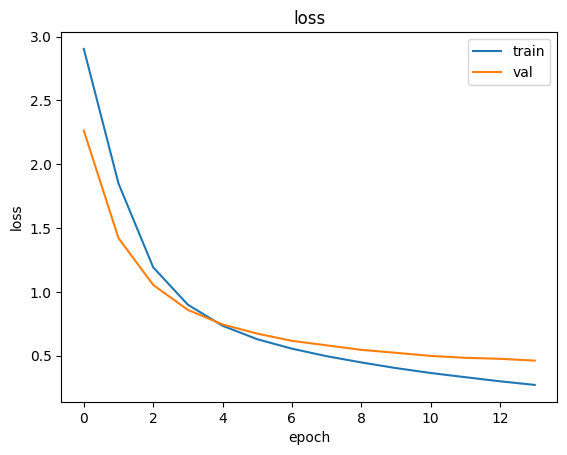

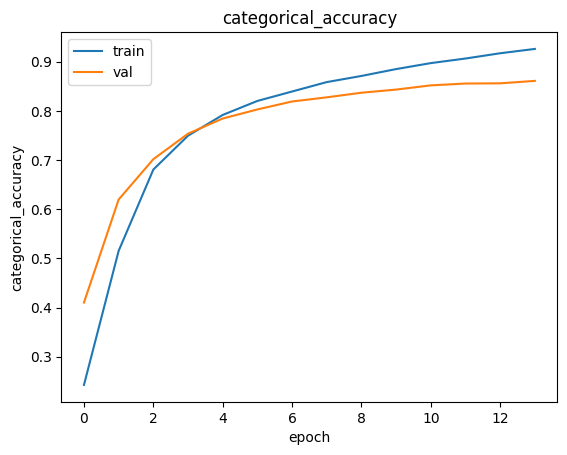

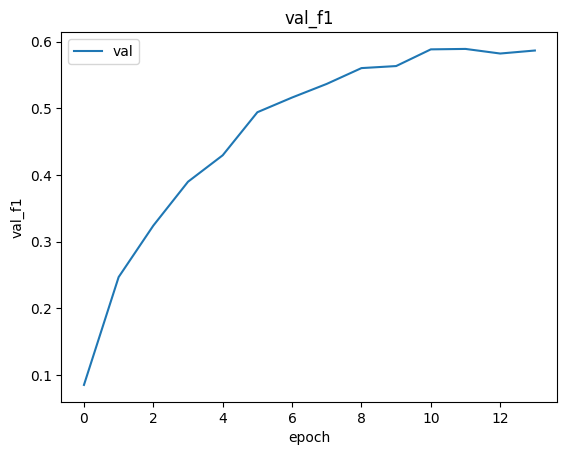

In [44]:
compile_info = {
    'optimizer': ks.optimizers.Adam(learning_rate=1e-2),
    'loss': 'categorical_crossentropy',
    'weighted_metrics': ['categorical_accuracy'],
}

prepared_train_data = prepare_data(train_data, tokenizer, label_encoder)
prepared_val_data = prepare_data(val_data, tokenizer, label_encoder)

callbacks = [
    get_f1_callback(prepared_val_data, pos_evaluator),
    ks.callbacks.EarlyStopping(monitor='val_f1', mode='max', patience=3, min_delta=5e-3)
]

training_info = {
    'verbose': 1,
    'epochs': 100,
    'batch_size': 256,
    'callbacks': callbacks
}

set_reproducibility(42)
model = model_factory.create_model(**models['base'])
model.compile(**compile_info)

train_dataloader = create_dataloader(prepared_train_data, batch_size=training_info['batch_size'])
val_dataloader = create_dataloader(prepared_val_data, batch_size=training_info['batch_size'], training=False)

history = train_model(model=model, train_data=train_dataloader, val_data=val_dataloader, training_info=training_info)

From the plot aboves, we see that around 10 epochs the learning curve starts to show a plateau. Therefore, this value may be a good point to evaluate different models and tune hyperparameters.

# 9. Experiments

In this section we want to:
1. find the best hyper parameters on the baseline model.
2. find the best preprocessing and embedding strategies on the baseline model.
3. find the best hyperparameters for different architectures defined above and choose the best two models. 

## 8.1 Tune baseline model 

- The evaluation of the model is done on the validation set by using macro F1.
- Hyperparameter tuning is done by using the Bayesian Optimization from keras_tuner library. 

In [83]:
class MyHyperModel(keras_tuner.HyperModel):
  def __init__(self, model_factory: ModelFactory, architectures: Dict[str, Dict], compile_info: dict, evaluation_fn=None) -> None:
    super().__init__()
    self.model_factory = model_factory
    self.architectures = architectures
    self.compile_info = compile_info
    self.evaluation_fn = evaluation_fn

  def build(self, hp: keras_tuner.HyperParameters) -> ks.Model:
    architecture = hp.Choice('architecture', list(self.architectures.keys()))
    hyperparameters={
        'rnn_units': hp.Int('rnn_units', min_value=32, max_value=512, step=32)
    }
    if 'additional_dense' in self.architectures:
      with hp.conditional_scope('architecture', 'additional_dense'):
        if architecture == 'additional_dense':
          hyperparameters['additional_dense_units'] = hp.Int('additional_dense_units', min_value=2, max_value=100, step=2)
    
    model = model_factory.create_model(**self.architectures[architecture], **hyperparameters)
    model.compile(**self.compile_info)

    return model

  # If the fit method returns an objective function instead of the history, this will be minimized.
  def fit(self, hp: keras_tuner.HyperParameters, model: ks.Model, validation_data, *fit_args, **fit_kwargs):
    print('Training ...')
    history = model.fit(*fit_args, validation_data=validation_data, **fit_kwargs)
    if self.evaluation_fn:
      print('Evaluating ...')
      y_true = get_unbatched_labels(validation_data)
      y_pred = model.predict(validation_data).to_tensor(0)
      return self.evaluation_fn(y_true, y_pred)
    else:
      return history

def get_tuner(hypermodel: keras_tuner.HyperModel, model_name, trials=10, **kwargs):
  return keras_tuner.BayesianOptimization(
    hypermodel=hypermodel,
    objective=keras_tuner.Objective('val_f1', 'max'),
    # No objective to specify.
    # Objective is the return value of `HyperModel.fit()`.
    max_trials=trials,
    num_initial_points=None,
    directory = "tuning",
    project_name=model_name,
    overwrite=True,
    seed=current_seed(),
    **kwargs
    )

For the baseline model, the only hyperparameter we need to tune is:
- rnn_units: dimension of the hidden state of the rnn layers [32:512:32]

In [96]:
def create_tuning_recipe(
    architecture,
    epochs=4,
    trials=10,
    text_strategy='lower',
    number_strategy=None,
    composed_words=False,
    seed=42,
    batch_size=256):

    compile_info = {
        'optimizer': ks.optimizers.Adam(learning_rate=5e-2), # we do not want to tune it now
        'loss': 'categorical_crossentropy',
        'weighted_metrics': ['categorical_accuracy']
    }

    set_reproducibility(seed)
    dataset, embedding_matrix = preprocess_and_load_embedding(df, text_strategy=text_strategy, number_strategy=number_strategy, composed_words=composed_words)
    tokenizer = TextVectorization(embedding_matrix.vocabulary(), sep=words_separator)
    label_encoder = LabelEncoder(label_vocabulary, sep=words_separator, ignore_padding=False)

    train_data, val_data, test_data = split_dataset(dataset)
    train_data = prepare_data(train_data, tokenizer, label_encoder)
    val_data = prepare_data(val_data, tokenizer, label_encoder)
    train_dataloader = create_dataloader(train_data, batch_size=batch_size)
    val_dataloader = create_dataloader(val_data, batch_size=batch_size, training=False)

    model_factory = ModelFactory(embedding_matrix.vectors(), n_classes=n_tags)
    evaluator = PosEvaluator(label_encoder, banned_tags=punctuation_tags)
    
    callbacks = [
        get_f1_callback(val_data, pos_evaluator),
        ks.callbacks.EarlyStopping(monitor='val_f1', mode='max', patience=3, min_delta=1e-2),
    ]

    architectures = {architecture: models[architecture]}
    hypermodel = MyHyperModel(model_factory, architectures=architectures, compile_info=compile_info)

    tuner = get_tuner(hypermodel, model_name=architecture, trials=trials)
    search_info = dict(
        x=train_dataloader,
        validation_data=val_dataloader,
        epochs=epochs,
        callbacks=callbacks        
    )

    return hypermodel, tuner, search_info

In [97]:
hypermodel, tuner, search_info = create_tuning_recipe('base', trials=10)
tuner.search_space_summary()

Search space summary
Default search space size: 2
architecture (Choice)
{'default': 'base', 'conditions': [], 'values': ['base'], 'ordered': False}
rnn_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}


In [98]:
tuner.search(**search_info)
tuner.results_summary()

Trial 3 Complete [00h 02m 19s]
val_f1: 0.495

Best val_f1 So Far: 0.52091
Total elapsed time: 00h 05m 45s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
base              |base              |architecture
320               |160               |rnn_units

Training ...
Epoch 1/4
8/8 [==============================] - ETA: 0s - loss: nan - categorical_accuracy: 0.0543  

KeyboardInterrupt: 

## 8.2 Tune preprocessing and embedding strategies

Since words in Glove are lower case, it doesn't make sense not to lowerize texts at all. Therefore, we compare the two text strategies first

embedding_strategies={
  'text_strategy': [None, 'lower', 'lower_up'],
  'number_strategy': [None, 'token'],
  'composed_words': [False, True],
}

## 8.3 Model Selection

In [ ]:
print('Banned tags with support > 0')
tags = np.unique(y_pred[tf_in(y_pred, evaluator.banned_tags)])
tags = label_encoder.ids_to_tokens(tags)
print(tags)

In [ ]:
labels = valid_labels + punctuation_tags
encoded_labels = list(label_encoder.tokens_to_ids(labels))

fig, ax = plt.subplots(figsize=(25,15))
cm = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=encoded_labels)
ConfusionMatrixDisplay(cm, display_labels=labels).plot(cmap='Blues', xticks_rotation='vertical', ax=ax);

# 2 Model Selection and Hypeparameters Tuning

In [ ]:
trials = 2
epochs = 1
tuner = keras_tuner.BayesianOptimization(
    hypermodel=hypermodel,
    # No objective to specify.
    # Objective is the return value of `HyperModel.fit()`.
    max_trials=trials,
    num_initial_points=None,
    project_name="tuning",
    overwrite=True,
    seed=current_seed()
)
tuner.search_space_summary()
tuner.search(x=train_dataloader, validation_data=val_dataloader, epochs=epochs)

In [ ]:
tuner.results_summary()

In [ ]:
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
model = build_model(best_hps[0])
# Fit with the entire dataset.
x_all = np.concatenate((x_train, x_val))
y_all = np.concatenate((y_train, y_val))
model.fit(x=x_all, y=y_all, epochs=1)